## Importacion de bibliotecas


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv("Dataset/archivo_limpio.csv")

In [15]:
df.columns

Index(['aerolinea', 'origen', 'destino', 'distancia_km', 'retraso', 'anio',
       'mes', 'es_fin_semana', 'bloque_horario', 'aerolinea_delay_rate',
       'origen_delay_rate', 'destino_delay_rate', 'ruta', 'ruta_delay_rate'],
      dtype='object')

## Creacion de features

### Tasa de retraso por aerolínea


In [6]:
delay_by_airline = df.groupby("aerolinea")["retraso"].mean()
df["aerolinea_delay_rate"] = df["aerolinea"].map(delay_by_airline)


### Tasa de retraso por aeropuerto

In [ ]:
#  Media global
global_mean = df["retraso"].mean()

#  Tasas históricas
delay_by_origin = df.groupby("origen")["retraso"].mean()
delay_by_destino = df.groupby("destino")["retraso"].mean()

#  Mapping
df["origen_delay_rate"] = (
    df["origen"]
    .map(delay_by_origin)
    .fillna(global_mean)
)

df["destino_delay_rate"] = (
    df["destino"]
    .map(delay_by_destino)
    .fillna(global_mean)
)



### Ruta


In [14]:
df["ruta"] = df["origen"] + "_" + df["destino"]
delay_by_route = df.groupby("ruta")["retraso"].mean()
df["ruta_delay_rate"] = df["ruta"].map(delay_by_route)


### Estación del año

In [ ]:
df["temporada"] = df["mes"].map({
    12:1, 1:1, 2:1,    # alta
    6:2, 7:2, 8:2,     # media
}).fillna(0)


### Riesgo horario

In [28]:
df['bloque_horario'].sample(10)

76720         tarde
108379        noche
18654        mañana
21567         tarde
113176        tarde
38922         noche
2001         mañana
43843         noche
27917     madrugada
62698        mañana
Name: bloque_horario, dtype: object

In [29]:
bloque_risk = {
    "madrugada": 2,
    "mañana": 4,
    "tarde": 1,
    "noche": 3
}
df["bloque_risk"] = df["bloque_horario"].map(bloque_risk)


### Oteas Interacciones

In [18]:
df["fin_semana_y_noche"] = (
    (df["es_fin_semana"] == 1) & (df["bloque_horario"] == "noche")
).astype(int)

df["ruta_larga"] = (df["distancia_km"] > df["distancia_km"].median()).astype(int)


### Dataset para el modelo

In [30]:
df_modelo = df[
    [
        "distancia_km",
        "mes",
        "es_fin_semana",
        "bloque_risk",
        "aerolinea_delay_rate",
        "origen_delay_rate",
        "destino_delay_rate",
        "ruta_delay_rate",
        "temporada",
        "fin_semana_y_noche",
        "ruta_larga",
        "retraso"
    ]
].copy()


In [31]:
df_modelo.head()

,distancia_km,mes,es_fin_semana,bloque_risk,aerolinea_delay_rate,origen_delay_rate,destino_delay_rate,ruta_delay_rate,temporada,fin_semana_y_noche,ruta_larga,retraso
0,7652,1,0,2,0.233933,0.365686,0.362849,0.354170,1.0,0,1,0
1,9813,1,0,2,0.897161,0.368406,0.370634,0.372366,1.0,0,1,1
2,2447,1,0,2,0.235823,0.368406,0.362849,0.371168,1.0,0,0,0
3,4744,1,0,2,0.897161,0.367868,0.362849,0.363592,1.0,0,0,1
4,8372,1,0,2,0.897161,0.365686,0.370634,0.370835,1.0,0,1,1


### Checks finales

#### Balance del target

In [32]:
df_modelo["retraso"].value_counts(normalize=True)


retraso
0    0.632325
1    0.367675
Name: proportion, dtype: float64

#### NaN

In [33]:
df_modelo.isna().sum()


distancia_km            0
mes                     0
es_fin_semana           0
bloque_risk             0
aerolinea_delay_rate    0
origen_delay_rate       0
destino_delay_rate      0
ruta_delay_rate         0
temporada               0
fin_semana_y_noche      0
ruta_larga              0
retraso                 0
dtype: int64

#### Comparación retraso vs no retraso

In [40]:
df_modelo.groupby("retraso").mean()


,distancia_km,mes,es_fin_semana,bloque_risk,aerolinea_delay_rate,origen_delay_rate,destino_delay_rate,ruta_delay_rate,temporada,fin_semana_y_noche,ruta_larga
retraso,,,,,,,,,,,
0,6261.105747,6.429908,0.285296,2.401600,0.255259,0.367667,0.367660,0.367630,0.762385,0.020190,0.500494
1,6242.183677,6.431790,0.286122,2.442578,0.561007,0.367688,0.367701,0.367753,0.760250,0.094739,0.498810


## Análisis de variables

### Correlación con el target

In [34]:
df_modelo.corr(numeric_only=True)["retraso"].sort_values(ascending=False)


retraso                 1.000000
aerolinea_delay_rate    0.552945
fin_semana_y_noche      0.168824
bloque_risk             0.017722
ruta_delay_rate         0.011109
destino_delay_rate      0.006361
origen_delay_rate       0.004586
es_fin_semana           0.000882
mes                     0.000265
temporada              -0.001233
ruta_larga             -0.001624
distancia_km           -0.002751
Name: retraso, dtype: float64

### Comparacion de medias por clase

In [35]:
df_modelo.groupby("retraso").mean()[[
    "aerolinea_delay_rate",
    "fin_semana_y_noche",
    "bloque_risk",
    "ruta_delay_rate"
]]


,aerolinea_delay_rate,fin_semana_y_noche,bloque_risk,ruta_delay_rate
retraso,,,,
0,0.255259,0.020190,2.401600,0.367630
1,0.561007,0.094739,2.442578,0.367753


### Boxplot por clase

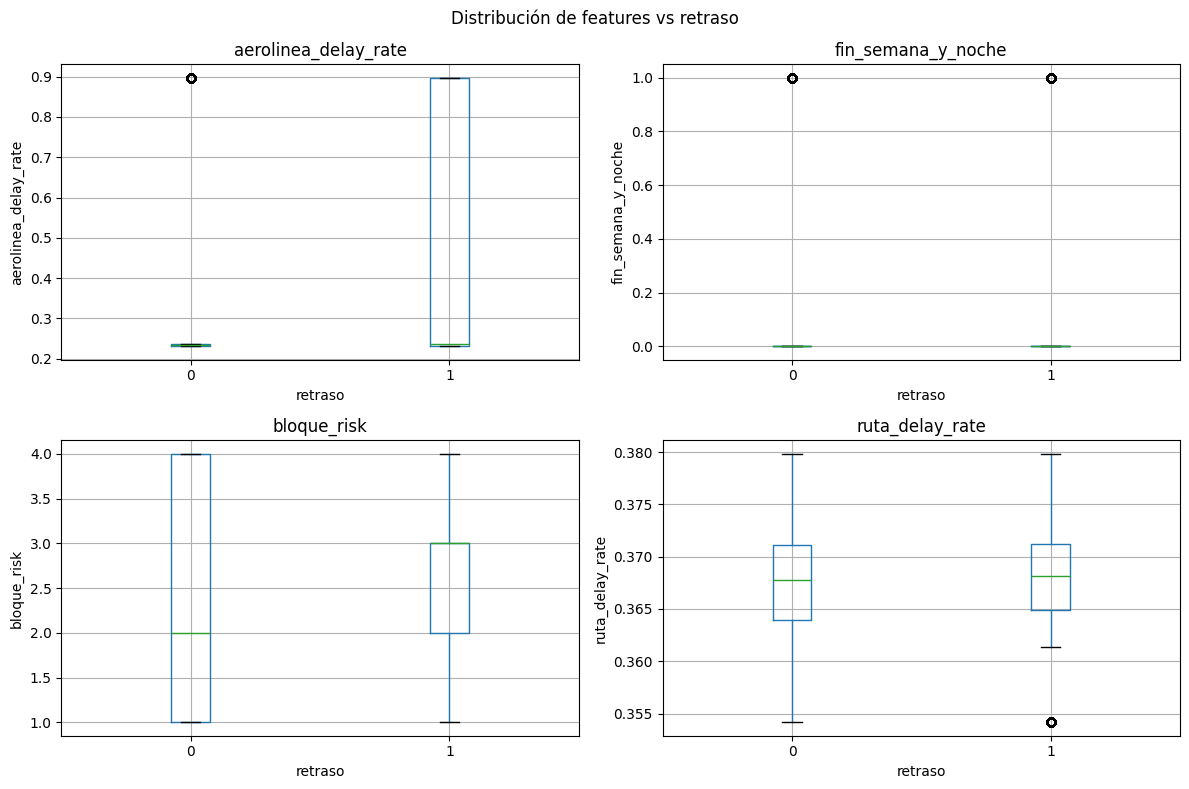

In [39]:
features = [
    "aerolinea_delay_rate",
    "fin_semana_y_noche",
    "bloque_risk",
    "ruta_delay_rate"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, feature in zip(axes.flatten(), features):
    df_modelo.boxplot(
        column=feature,
        by="retraso",
        ax=ax
    )
    ax.set_title(feature)
    ax.set_xlabel("retraso")
    ax.set_ylabel(feature)

plt.suptitle("Distribución de features vs retraso")
plt.tight_layout()
plt.show()

### Insides

#### **aerolinea_delay_rate es la correlacion mas grande**
No retraso (0): 0.255
Retraso (1):    0.561
→   Esta feature separa muy bien retrasos vs no retrasos
    
    Va a ser la feature más importante del modelo

#### **fin_semana_y_noche aporta señal real**
0: 0.020
1: 0.095
→   La mayoría de los valores están en 0
    
    Hay más 1 cuando retraso = 1 que cuando retraso = 0
    
    buena interacción, vale la pena

#### **bloque_risk**
0: 2.40
1: 2.44
→   Para retraso = 1, la mediana es un poco más alta
    
    Hay mucha superposición entre clasecor
    
    Corelacion pequeña. debil pero usable
    
    No discrimina fuerte por sí sola
    
    Tiene sentido operacional

#### **ruta_delay_rate**
0: 0.367630
1: 0.367753 
→   A nivel global, la ruta sola no separa mucho
    
    Puede ser redundante con origen/destino / Mucha superposición 
    
    Medianas prácticamente iguales
    
    A nivel global, esta feature aporta poco sola


Las demás:
No muestran correlación lineal fuerte

#### Multicolinealidad

In [ ]:
# Matriz de correlación entre features

df_modelo.corr().abs()


,distancia_km,mes,es_fin_semana,bloque_risk,aerolinea_delay_rate,origen_delay_rate,destino_delay_rate,ruta_delay_rate,temporada,fin_semana_y_noche,ruta_larga,retraso
distancia_km,1.000000,1.874017e-03,2.646080e-03,1.032796e-03,0.001132,0.001805,0.001142,0.000500,2.558160e-03,0.003197,0.866321,0.002751
mes,0.001874,1.000000e+00,5.034352e-04,9.437535e-18,0.000917,0.002180,0.004850,0.007889,2.570780e-02,0.000178,0.000882,0.000265
es_fin_semana,0.002646,5.034352e-04,1.000000e+00,1.424858e-17,0.001752,0.001797,0.000536,0.002942,2.995929e-04,0.353578,0.005065,0.000882
bloque_risk,0.001033,9.437535e-18,1.424858e-17,1.000000e+00,0.000302,0.001765,0.003196,0.000149,3.172323e-16,0.116968,0.000953,0.017722
aerolinea_delay_rate,0.001132,9.165865e-04,1.751943e-03,3.023216e-04,1.000000,0.001487,0.004214,0.005721,3.416573e-03,0.001722,0.002037,0.552945
origen_delay_rate,0.001805,2.180208e-03,1.796983e-03,1.764834e-03,0.001487,1.000000,0.162021,0.412787,2.887305e-03,0.002766,0.000414,0.004586
destino_delay_rate,0.001142,4.850031e-03,5.357593e-04,3.196026e-03,0.004214,0.162021,1.000000,0.572596,7.656827e-03,0.000476,0.001445,0.006361
ruta_delay_rate,0.000500,7.888645e-03,2.942425e-03,1.492720e-04,0.005721,0.412787,0.572596,1.000000,7.281092e-03,0.003847,0.000610,0.011109
temporada,0.002558,2.570780e-02,2.995929e-04,3.172323e-16,0.003417,0.002887,0.007657,0.007281,1.000000e+00,0.000106,0.000268,0.001233
fin_semana_y_noche,0.003197,1.780037e-04,3.535781e-01,1.169675e-01,0.001722,0.002766,0.000476,0.003847,1.059295e-04,1.000000,0.005927,0.168824


### Dataset final


In [42]:
features = [
    "aerolinea_delay_rate",
    "fin_semana_y_noche",
    "bloque_risk",
    "distancia_km",
    "origen_delay_rate",
    "destino_delay_rate",
    "retraso"
]

data = df_modelo[features].copy()

In [44]:

data.to_csv("Dataset/dataset.csv", index=False)
